In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from datetime import timedelta

## Covid-19 in Europe
**This is not science, but a small programming exercise**<br>
Making inferences from a very limited set of data points, ignoring lots of other factors.
<p>Using data from EU https://www.ecdc.europa.eu/en/covid-19/data
In particular, reported cases per 14-day period and country, and government measures. <br>
<p>Metadata:<br>
https://www.ecdc.europa.eu/sites/default/files/documents/2021-01-13_Variable_Dictionary_and_Disclaimer_national_weekly_data.pdf <br>
https://www.ecdc.europa.eu/sites/default/files/documents/Variable_Dictionary_and_Disclaimer_non-pharmacautical_measures_v3.pdf <br>

In [2]:
# Refresh data from source if necessary
datadir = "../data"
def get_csv_from_url(url, fname):
    df = pd.read_csv(url)
    df.shape
    df.to_csv(fname)

try:
    os.mkdir(datadir)
except FileExistsError:
    pass

get_csv_from_url("https://opendata.ecdc.europa.eu/covid19/nationalcasedeath/csv", \
                (datadir + "/eu-14d-notification-data.csv"))
get_csv_from_url("https://www.ecdc.europa.eu/sites/default/files/documents/response_graphs_data_2021-03-25.csv", \
                (datadir + "/eu-response-data.csv"))

In [3]:
measuredf = pd.read_csv(datadir + "/eu-response-data.csv", parse_dates=["date_start", "date_end"])
print(f"{measuredf.shape}")
measuredf.head(2)

(1557, 5)


,Unnamed: 0,Country,Response_measure,date_start,date_end
0,0,Austria,AdaptationOfWorkplace,2020-03-16,2020-04-13
1,1,Austria,BanOnAllEvents,2020-11-03,NaT


In [4]:
print("NaT in date_start:\t", np.isnat(measuredf.date_start).sum())
print("NaT in date_end:\t", np.isnat(measuredf.date_end).sum())

NaT in date_start:	 0
NaT in date_end:	 440


*date_end* = NaT means the measure is still on. Replace those values with tomorrow's date for further processing.

In [5]:
measuredf.date_end.replace(to_replace=pd.NaT,value=(datetime.today()+ timedelta(days=1)).date(), inplace=True)

In [6]:
eu_countries = measuredf.Country.unique()
eu_countries

array(['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia',
       'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece',
       'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia',
       'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
       'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia',
       'Spain', 'Sweden', 'Switzerland', 'United Kingdom'], dtype=object)

In [7]:
notifdf = pd.read_csv(datadir + '/eu-14d-notification-data.csv')
notifdf.shape

(25492, 11)

In [8]:
#eu_notif = notifdf[notifdf.country.str.contains('|'.join(eu_countries)).any(level=0)]
eu_notif = notifdf[notifdf.country.isin(eu_countries)]
del notifdf

In [9]:
eu_notif.shape

(4040, 11)

In [10]:
# Focus on number of cases only
eu_cases = eu_notif[eu_notif.indicator=='cases'].drop(['source'],axis=1)
del eu_notif
eu_cases.shape

(2020, 10)

For later processing, derive dates from the *year_week* values

In [11]:
import my_helpers

#eu_cases['wk_start'] = pd.to_datetime((eu_cases.year_week + '-1'), format='%Y-%W-%w')
eu_cases['wk_start'] = eu_cases.year_week.apply( lambda x: my_helpers.yearWeekToDateTime(x))
eu_cases['month'] = eu_cases.wk_start.dt.month
eu_cases.shape

(2020, 12)

The *rate_14_day* is an interesting measure because it's relative to population size. Not directly comparable across countries, though.<br>
https://www.ecdc.europa.eu/sites/default/files/documents/2021-01-13_Variable_Dictionary_and_Disclaimer_national_weekly_data.pdf

In [12]:
eu_cases[(eu_cases.year_week=='2021-12')]\
.groupby('country').agg({'rate_14_day':['mean']}).sort_values(by=[('rate_14_day', 'mean')],ascending=False)

,rate_14_day
,mean
country,
Estonia,1364.057741
Hungary,1196.864618
Czechia,1069.315993
Poland,923.219680
Bulgaria,722.090628
France,703.989126
Sweden,686.946392
Slovenia,590.974306


In [13]:
eu_cases.head()

,Unnamed: 0,country,country_code,continent,population,indicator,weekly_count,year_week,rate_14_day,cumulative_count,wk_start,month
1700,1700,Austria,AUT,Europe,8901064,cases,0,2020-01,NaN,0,2019-12-30,12
1701,1701,Austria,AUT,Europe,8901064,cases,0,2020-02,0.0,0,2020-01-06,1
1702,1702,Austria,AUT,Europe,8901064,cases,0,2020-03,0.0,0,2020-01-13,1
1703,1703,Austria,AUT,Europe,8901064,cases,0,2020-04,0.0,0,2020-01-20,1
1704,1704,Austria,AUT,Europe,8901064,cases,0,2020-05,0.0,0,2020-01-27,1


In [14]:
country_comparison_df = pd.DataFrame()
country_comparison_df["wk_start"] = eu_cases.wk_start.unique()
country_comparison_df.shape
## Executing all in a for loop kills the kernel of my little vm...
#for country in eu_countries:
#    country_comparison_df = pd.merge(country_comparison_df, eu_cases[eu_cases.country==country].loc[:,["wk_start","rate_14_day"]], on="wk_start")

(66, 1)

Picking a few countries - Finland and neighbouring countries, and some known to have high rates. 

In [15]:
country_comparison_df = pd.merge(country_comparison_df, eu_cases[eu_cases.country=="Belgium"].loc[:,["wk_start","rate_14_day"]], on="wk_start")
country_comparison_df = pd.merge(country_comparison_df, eu_cases[eu_cases.country=="Czechia"].loc[:,["wk_start","rate_14_day"]], on="wk_start")
country_comparison_df = pd.merge(country_comparison_df, eu_cases[eu_cases.country=="Denmark"].loc[:,["wk_start","rate_14_day"]], on="wk_start")
country_comparison_df = pd.merge(country_comparison_df, eu_cases[eu_cases.country=="Estonia"].loc[:,["wk_start","rate_14_day"]], on="wk_start")
country_comparison_df = pd.merge(country_comparison_df, eu_cases[eu_cases.country=="Finland"].loc[:,["wk_start","rate_14_day"]], on="wk_start")
country_comparison_df = pd.merge(country_comparison_df, eu_cases[eu_cases.country=="Norway"].loc[:,["wk_start","rate_14_day"]], on="wk_start")
country_comparison_df = pd.merge(country_comparison_df, eu_cases[eu_cases.country=="Sweden"].loc[:,["wk_start","rate_14_day"]], on="wk_start")
country_comparison_df = pd.merge(country_comparison_df, eu_cases[eu_cases.country=="United Kingdom"].loc[:,["wk_start","rate_14_day"]], on="wk_start")
country_comparison_df.columns=["wk_start", "Belgium", "Czechia", "Denmark", "Estonia", "Finland", "Norway", "Sweden", "United Kingdom"]
print(country_comparison_df.shape)
country_comparison_df.head(3)

(66, 9)


,wk_start,Belgium,Czechia,Denmark,Estonia,Finland,Norway,Sweden,United Kingdom
0,2019-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

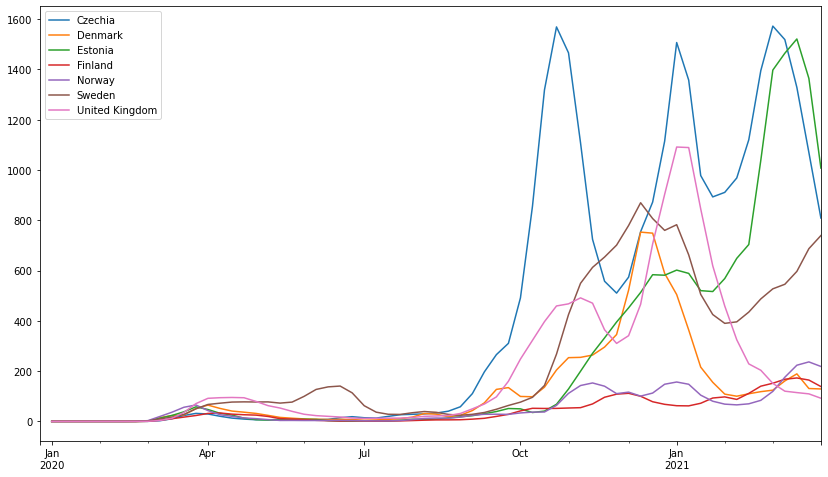

In [16]:
country_comparison_df.plot(x="wk_start", y=["Czechia","Denmark", "Estonia", "Finland", "Norway", "Sweden", "United Kingdom"], xlabel="", figsize=(14,8))

## Infection rates and impact of measures
Some countries have dramatic peaks.
What governmental measures could have an impact on the infection rates?
Rather than looking at *rate_14_day* as such, we want to examine it's change from one period to another. Is the disease spreading faster or slower?

In [17]:
#https://www.dataindependent.com/pandas/pandas-diff/
country_diff = country_comparison_df.set_index("wk_start").diff(periods=1, axis=0)

<AxesSubplot:xlabel='wk_start', ylabel='Change in weekly cases'>

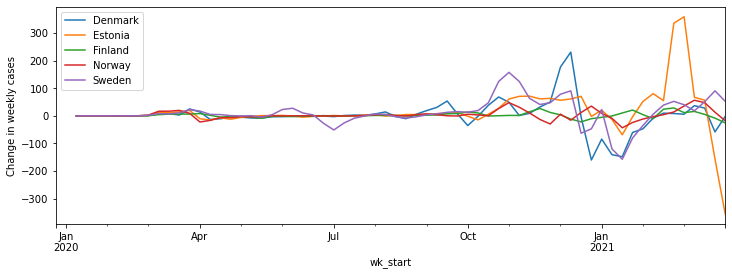

In [18]:
country_diff.plot(y=["Denmark", "Estonia", "Finland", "Norway", "Sweden"], ylabel="Change in weekly cases", figsize=(12,4))

Denmark and Estonia had infection rates growing exponentially, then rapidly decreasing. The countries also took measures to stop the spread. Let's investigate.

In [19]:
measuredf[((measuredf.Country=="Denmark") | (measuredf.Country=="Estonia") )& (measuredf.date_start>datetime(2020,10,1))].sort_values( \
                                                                                                        by=["Country", "date_start"])

,Unnamed: 0,Country,Response_measure,date_start,date_end
338,338,Denmark,BanOnAllEvents,2020-10-26,2021-04-10
360,360,Denmark,MassGather50,2020-10-26,2021-04-10
371,371,Denmark,PrivateGatheringRestrictions,2020-10-26,2021-04-10
341,341,Denmark,ClosHigh,2020-12-16,2021-02-28 00:00:00
346,346,Denmark,ClosPubAny,2020-12-16,2021-04-10
350,350,Denmark,ClosSec,2020-12-16,2021-02-28 00:00:00
352,352,Denmark,EntertainmentVenues,2020-12-16,2021-04-10
354,354,Denmark,GymsSportsCentres,2020-12-16,2021-04-10
364,364,Denmark,NonEssentialShops,2020-12-16,2021-02-28 00:00:00
373,373,Denmark,RestaurantsCafes,2020-12-16,2021-04-10


Lot's of different measures. Try bundling.
In Denmark, various measures beginning 26.10.2020 and 16.12.2020. Most of them are still on.
In Estonia, lots of measures since beginning of March 2021. 
Let's simply regard the measures as Lockdown and plot the lockdown period against the changes in daily new cases.
Based on the file metadata descriptions, the above measures are not "lockdown" because they are not strictly enforced like "StayHomeOrder".  

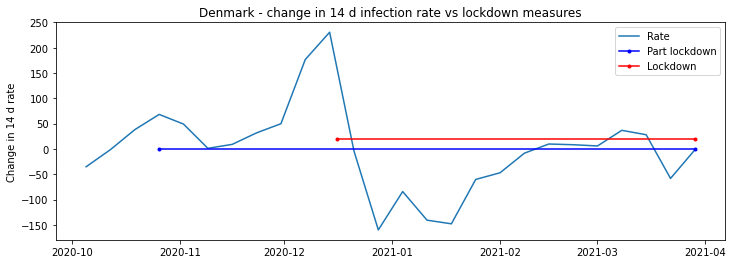

In [20]:
# The combination of pandas plot and pyplot worked, then stopped working. Strange... Need to do all pyplot, then.
#country_diff[datetime(2020,10,1):].plot(y="Denmark", xlabel="", ylabel="Change in weekly cases", figsize=(12,4))
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot()
end_date=country_diff.index.max()
ax.plot(country_diff[datetime(2020,10,1):].index, country_diff[datetime(2020,10,1):].Denmark)
ax.set_ylabel("Change in 14 d rate")
ax.plot([datetime(2020,10,26),end_date], [0,0], color='b', marker=".")
ax.plot([datetime(2020,12,16),end_date], [20,20], color='r', marker=".")
ax.legend(["Rate", "Part lockdown", "Lockdown"])
ax.set_title("Denmark - change in 14 d infection rate vs lockdown measures")
plt.show()

Looking at these observations alone, it would seem the new lockdown measures in mid-December 2020 did stop the exponential growth. <br>Looking closer, the growth was slowing down before the measures took place. 
The infection rate is a lagging indicator. It's a weekly rolling average(?) of previous 14 days, and there's also the incubation time, so even if the infections would go to zero on day 1 of the lockdown, it would only be visible at least a week later. <br>
The intuition is that the lockdown should have an impact on the infection rate, but there are of course lots of other factors at play, too. For whatever reasons, exponential growth always comes to an end.

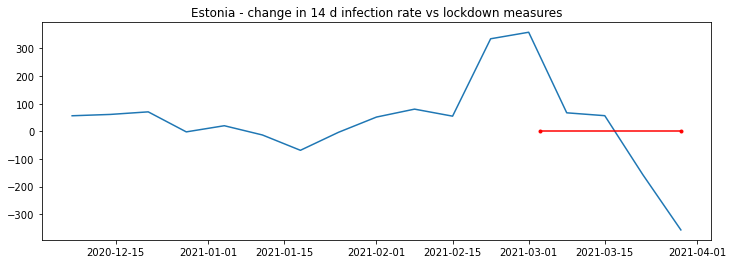

In [88]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot()
ax.plot(country_diff[datetime(2020,12,1):].index, country_diff[datetime(2020,12,1):].Estonia)
ax.plot([datetime(2021,3,3),end_date], [0,0], color='r',  marker=".")
ax.set_title("Estonia - change in 14 d infection rate vs lockdown measures")
plt.show()

The pattern is similar to that in Denmark. Infection rate is slowing down before the lockdown.<br>
Try to look at data that is updated more frequently. 
Metadata:<br>
https://www.ecdc.europa.eu/sites/default/files/documents/Description-and-disclaimer_daily_reporting.pdf

In [84]:
def prepDailyRates():
    #get daily cases
    df = pd.read_csv("https://opendata.ecdc.europa.eu/covid19/nationalcasedeath_eueea_daily_ei/csv/data.csv")    
    df.loc[:,"dateRep"] = pd.to_datetime(df.loc[:,"dateRep"], format="%d/%m/%Y")
    # on day 1, countries report all cases before day 1
    day1 = df.dateRep.min() + timedelta(days=1)
    df = df.loc[df.dateRep>day1]
    return df

try:
    print(df.shape)
except NameError:
        df = prepDailyRates()



(1139, 11)


<AxesSubplot:>

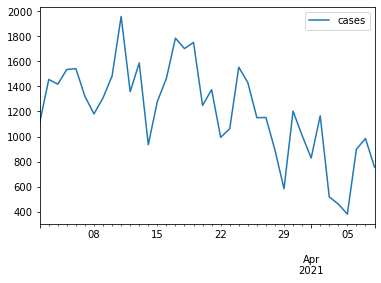

In [83]:
df.loc[(df.countriesAndTerritories=="Estonia")].plot(x="dateRep", y="cases", xlabel="")

This data doesn't help. It's only available from March 2021 on, and the weekly cycle interferes.<br>
Try another dataset.

In [101]:
def loadDailyData():
    get_csv_from_url("https://opendata.ecdc.europa.eu/covid19/subnationalcasedaily/csv", \
                    (datadir + "/eu-14d-daily-data.csv"))
    df = pd.read_csv(datadir + "/eu-14d-daily-data.csv")
    print(df.shape)
    df = df.dropna()
    print(df.shape)
    df.loc[:,"date"] = pd.to_datetime(df.loc[:,"date"], format="%Y-%m-%d")
    df = df.sort_values(by=["country", "region_name", "date"])
    return df

df = loadDailyData()    

(74642, 7)
(72314, 7)


In [113]:
df.loc[df.country=="Denmark"].region_name.unique()

array(['Bornholm', 'Byen København', 'Fyn', 'Københavns omegn',
       'Nordjylland', 'Nordsjælland', 'Sydjylland',
       'Vest- og Sydsjælland', 'Vestjylland', 'Østjylland', 'Østsjælland'],
      dtype=object)

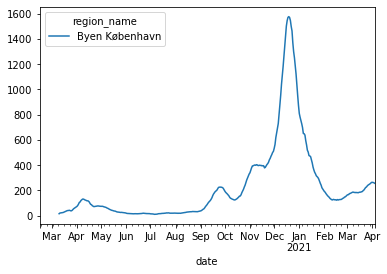

Stricter measures started 2020-12-16
In Copenhagen, the peak was on 2020-12-19 00:00:00
In Copenhagen surrondings, the peak was on 2020-12-23 00:00:00


In [130]:
plotdf = df.pivot(index="date", columns="region_name", values="rate_14_day_per_100k")
plotdf.plot( y=["Byen København"])
plt.show()
print("Stricter measures started 2020-12-16")
print(f'In Copenhagen, the peak was on { df.loc[df.loc[df.region_name=="Byen København"].rate_14_day_per_100k.idxmax()].date }')
print(f'In Copenhagen surrondings, the peak was on { df.loc[df.loc[df.region_name=="Københavns omegn"].rate_14_day_per_100k.idxmax()].date }')

Even accounting for the delay in reporting *(infections reported on 2020-12-20 may have been contracted around 2020-12-10)*, <br>
the slowdown would hardly have been so drastic without lockdown measures.

# Conclusions
None, really. <br>
This is just eyeball analytics with few variables.
# Next steps
Proper hypothesis testing. Apply Interrupted Time Series? Closer categorisation of government measures and check for significance?<br>
Maybe later...

In [131]:
del plotdf

In [132]:
df.groupby(["date", "country", ""])

(72314, 7)

In [8]:
import re
stayhome = measuredf[measuredf.Response_measure.str.contains('stayhome', flags=re.IGNORECASE)]
stayhome.shape

(108, 4)

In [22]:
stayhome

,Country,Response_measure,date_start,date_end
59,Austria,StayHomeGen,2020-03-10,2020-03-15
60,Austria,StayHomeOrder,2020-03-16,2020-04-30
61,Austria,StayHomeOrder,2020-11-17,2021-02-07
62,Austria,StayHomeOrderPartial,2020-11-03,2020-11-16
63,Austria,StayHomeOrderPartial,2021-02-08,NaN
...,...,...,...,...
1551,United Kingdom,StayHomeOrder,2020-11-05,2020-12-01
1552,United Kingdom,StayHomeOrderPartial,2020-05-10,2020-07-04
1553,United Kingdom,StayHomeRiskG,2020-03-16,2020-07-05
1554,United Kingdom,StayHomeRiskG,2020-11-05,2020-12-01


In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv")
df.dtypes

location                                object
iso_code                                object
date                                    object
total_vaccinations                     float64
people_vaccinated                      float64
people_fully_vaccinated                float64
daily_vaccinations_raw                 float64
daily_vaccinations                     float64
total_vaccinations_per_hundred         float64
people_vaccinated_per_hundred          float64
people_fully_vaccinated_per_hundred    float64
daily_vaccinations_per_million         float64
dtype: object

In [3]:
df[df.iso_code=="USA"].head()

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million
9624,United States,USA,2020-12-20,556208.0,556208.0,NaN,NaN,NaN,0.17,0.17,NaN,NaN
9625,United States,USA,2020-12-21,614117.0,614117.0,NaN,57909.0,57909.0,0.18,0.18,NaN,173.0
9626,United States,USA,2020-12-22,NaN,NaN,NaN,NaN,127432.0,NaN,NaN,NaN,381.0
9627,United States,USA,2020-12-23,1008025.0,1008025.0,NaN,NaN,150606.0,0.30,0.30,NaN,450.0
9628,United States,USA,2020-12-24,NaN,NaN,NaN,NaN,191001.0,NaN,NaN,NaN,571.0


In [4]:
df.groupby(["location"]).agg({"people_vaccinated_per_hundred":["max","std"]}).dropna().sort_values(by=[('people_vaccinated_per_hundred', 'max')],ascending=False)

people_vaccinated_per_hundred           
                                           max        std
location                                                 
Gibraltar                                92.62  26.703740
Seychelles                               64.76  18.908720
Falkland Islands                         62.79  27.217316
Israel                                   60.59  19.176662
Saint Helena                             51.18  34.945217
...                                        ...        ...
Venezuela                                 0.05   0.026300
Vietnam                                   0.05   0.018631
Pakistan                                  0.03   0.012910
Gabon                                     0.01   0.007071
Iran                                      0.01   0.005774

[154 rows x 2 columns]